## Preprocessing

In [1]:
from nilearn import plotting
%matplotlib inline
import os
import json
from nipype.interfaces import fsl 
from nipype.interfaces import spm
from nipype.interfaces.spm import (Realign, SliceTiming, Coregister,  NewSegment,  Normalize12, Smooth)
from nipype.interfaces import matlab as mlab
from nipype.interfaces.io import SelectFiles, DataSink
from nipype.algorithms import rapidart as ra
from nipype.interfaces.utility import IdentityInterface
from nipype import Workflow, Node

In [2]:
spm.SPMCommand.set_mlab_paths(paths=os.path.abspath(os.path.join(os.environ['HOME'], 'Documents/MATLAB/spm12/')), matlab_cmd='/soft/matlab_hd/R2020b/bin/glnxa64/MATLAB -nodesktop -nosplash')

stty: 'standard input': Inappropriate ioctl for device


In [3]:
mlab.MatlabCommand.set_default_matlab_cmd("/soft/matlab_hd/R2020b/bin/glnxa64/MATLAB  -nodesktop -nosplash")
mlab.MatlabCommand.set_default_paths(os.path.abspath(os.path.join(os.environ['HOME'], 'Documents/MATLAB/spm12/')))

In [4]:
# spm.SPMCommand().version

In [5]:
fsl.FSLCommand.set_default_output_type('NIFTI')

In [6]:
base_dir = os.path.join(os.environ['HOME'], 'spmbasics/data/')

In [7]:
experiment_dir = os.path.join(base_dir, 'output')
output_dir = 'datasink'
working_dir = 'workingdir'

# list of subject identifiers
subject_id = ['01']

task_id = ['auditory']

# task_id = ['auditory']
# TR of functional images
with open(os.path.join(base_dir, 'MoAEpilot/task-auditory_bold.json'), 'rt') as fp:
    task_info = json.load(fp)
TR = task_info['RepetitionTime']

# Smoothing width used during preprocessing
fwhm = [6]

In [8]:
# Infosource - a function free node to iterate over the list of subject names
infosource = Node(IdentityInterface(fields=['subject_id', 'task_name']),
                  name="infosource")
infosource.iterables = [('subject_id', subject_id),
                        ('task_name', task_id)]
# SelectFiles - to grab the data (alternativ to DataGrabber)
anat_file = os.path.join( base_dir, 'MoAEpilot/', 'sub-{subject_id}', 'anat',  'sub-{subject_id}_T1w.nii' )
func_file = os.path.join( base_dir, 'MoAEpilot/', 'sub-{subject_id}', 'func',
                'sub-{subject_id}_task-{task_name}_bold.nii')

templates = {'anat': anat_file,
             'func': func_file}
selectfiles = Node(SelectFiles(templates,
                               base_directory=base_dir),
                   name="selectfiles")

# Datasink - creates output folder for important outputs
datasink = Node(DataSink(base_directory=experiment_dir,
                         container=output_dir),
                name="datasink")

In [9]:
realigner = Node(interface=Realign(), name='realign')
# realigner.inputs.in_files = func_file
realigner.inputs.register_to_mean = True
realigner.inputs.fwhm = 5
realigner.inputs.interp = 2
realigner.inputs.quality = 0.9
realigner.inputs.separation = 4
realigner.inputs.wrap = [0, 0, 0]
realigner.inputs.write_which = [2, 1]
realigner.inputs.write_interp = 4 
realigner.inputs.write_wrap = [0, 0, 0]
realigner.inputs.write_mask = True
realigner.inputs.jobtype = 'estwrite'
realigner.inputs.out_prefix = 'r'

In [10]:
slicetiming = Node(interface=SliceTiming(), name = 'slicetiming')
# st.inputs.in_files = anat_file
slicetiming.inputs.num_slices = 64
slicetiming.inputs.time_repetition = 7.
slicetiming.inputs.time_acquisition = 6.8906
slicetiming.inputs.slice_order = list(range(64,0,-1))
slicetiming.inputs.ref_slice = 32
slicetiming.inputs.out_prefix = 'a'

https://github.com/nipy/nipype/issues/2697 check this

In [11]:
coregister = Node(Coregister(), name="coregister")
coregister.inputs.jobtype = 'estimate'
coregister.inputs.cost_function = 'nmi'
coregister.inputs.fwhm = [7.0, 7.0]
coregister.inputs.separation = [4.0, 2.0]
coregister.inputs.tolerance = [0.02, 0.02, 0.02, 0.001, 0.001, 0.001, 0.01, 0.01, 0.01, 0.001, 0.001, 0.001]

In [12]:
tpm_path = os.path.abspath(os.path.join(os.environ['HOME'], 'Documents/MATLAB/spm12/tpm/', 'TPM.nii'))

In [13]:
segment =  Node(NewSegment(), name="newsegment")
# seg.inputs.channel_files = '/data/preproc/coregister/sub-01_T1w.nii'
#seg.inputs.channel_files = '/data/MoAEpilot_raw/sub-01/anat/sub-01_T1w.nii'
segment.inputs.affine_regularization = 'mni'
segment.inputs.channel_info = (0.001, 60, (False, True)) #save bias corrected map
tissue1 = ((tpm_path, 1), 1, (True, False), (False, False))
tissue2 = ((tpm_path, 2), 1, (True, False), (False, False))
tissue3 = ((tpm_path, 3), 2, (True, False), (False, False))
tissue4 = ((tpm_path, 4), 3, (True, False), (False, False))
tissue5 = ((tpm_path, 5), 4, (True, False), (False, False))
tissue6 = ((tpm_path, 6), 2, (False, False), (False, False))
segment.inputs.tissues = [tissue1, tissue2, tissue3, tissue4, tissue5, tissue6]
segment.inputs.warping_regularization = [0, 0.001, 0.5, 0.05, 0.2]
segment.inputs.sampling_distance = 3
segment.inputs.write_deformation_fields = [False, True] 

stty: 'standard input': Inappropriate ioctl for device


In [14]:
normalize = Node(Normalize12(), name="normalize") #old normalize now
normalize.inputs.jobtype = 'write'
normalize.inputs.write_bounding_box =  [[-78, -112, -70], [78, 76, 85]]
normalize.inputs.write_voxel_sizes = [3, 3, 3]
normalize.inputs.write_interp = 4
normalize.inputs.out_prefix = 'w'

In [15]:
smooth = Node(Smooth(), name="smooth")
smooth.inputs.fwhm = [6, 6, 6]
smooth.inputs.data_type = 0
smooth.inputs.implicit_masking = False
smooth.inputs.out_prefix = 's'

In [16]:
art = Node(ra.ArtifactDetect(), name="art")
art.inputs.use_differences = [True, False]
art.inputs.use_norm = True
art.inputs.norm_threshold = 1
art.inputs.zintensity_threshold = 3
art.inputs.mask_type = 'spm_global'
art.inputs.parameter_source = 'SPM'
art.inputs.plot_type='svg'

In [17]:
def get_vox_dims(volume):
    import nibabel as nb
    if isinstance(volume, list):
        volume = volume[0]
    nii = nb.load(volume)
    hdr = nii.header
    voxdims = hdr.get_zooms()
    return [float(voxdims[0]), float(voxdims[1]), float(voxdims[2])]

In [18]:
preproc = Workflow(name='block_preproc_art')
preproc.base_dir = os.path.join(experiment_dir, working_dir)

In [21]:
preproc.connect([(infosource, selectfiles, [('subject_id', 'subject_id'),
                                            ('task_name', 'task_name')]),
                 (selectfiles, realigner, [('func', 'in_files')]),
                 (realigner, slicetiming, [('realigned_files', 'in_files')]),
                 (realigner, coregister, [('mean_image', 'source'), 
                                          ('realigned_files', 'apply_to_files')]),
                 (realigner, datasink, [('realignment_parameters', 'preproc.@realignement_parameters')]),
                 (selectfiles, coregister, [('anat', 'target')]), 
                 (coregister, datasink, [('coregistered_source', 'preproc.@coregisered_source'),
                                         ('coregistered_files', 'preproc.@coregistered_files')]),
                 (coregister, segment, [('coregistered_source', 'channel_files')]),
                 (segment, datasink, [('bias_corrected_images', 'preproc.@bias_corrected_images'), 
                                 ('transformation_mat', 'preproc.@transformation_mat'),
                                 ('native_class_images', 'preproc.@native_class_images'),
                                 ('forward_deformation_field', 'preproc.@forward_deformation_field')]),
                 (segment, normalize, [('forward_deformation_field', 'deformation_file')]),
                 (slicetiming, normalize, [('timecorrected_files', 'apply_to_files'),
                                          (('timecorrected_files', get_vox_dims),
                                     'write_voxel_sizes')]),
                 (normalize, smooth, [('normalized_files', 'in_files')]),
                 (smooth, datasink, [('smoothed_files', 'preproc.@smoothed_files')]),
                 (realigner, art, [('realignment_parameters', 'realignment_parameters')]),
                 (normalize, art, [('normalized_files', 'realigned_files')]),
                 (art, datasink, [('outlier_files', 'preproc.@outlier_files'),
                                  ('plot_files', 'preproc.@plot_files')]),
])

In [27]:
preproc.write_graph(graph2use='colored', format='png', dotfilename='colored_graph.dot', simple_form=True)

240517-16:49:54,201 nipype.workflow INFO:
	 Generated workflow graph: /home/matay/spmbasics/data/output/workingdir/block_preproc_art/colored_graph.png (graph2use=colored, simple_form=True).


'/home/matay/spmbasics/data/output/workingdir/block_preproc_art/colored_graph.png'

240517-16:46:33,356 nipype.workflow INFO:
	 Generated workflow graph: /home/matay/spmbasics/data/output/workingdir/block_preproc_art/colored_graph.png (graph2use=colored, simple_form=True).


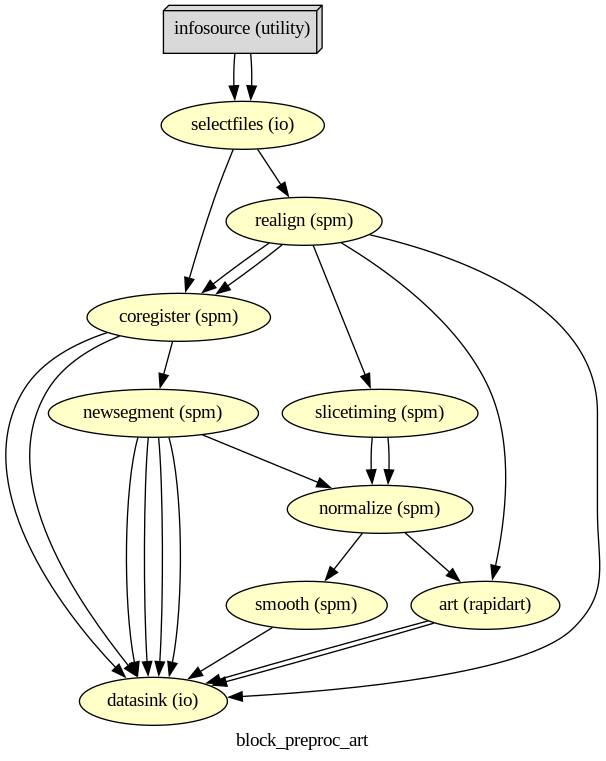

In [23]:
# Create preproc output graph
preproc.write_graph(graph2use='colored', format='png', dotfilename='colored_graph.dot', simple_form=True)

# Visualize the graph
from IPython.display import Image
Image(filename='/home/matay/spmbasics/data/output/workingdir/block_preproc_art/colored_graph.png', width=750)

In [24]:
preproc.write_graph(graph2use='flat', format='png', simple_form=True, dotfilename='flat_graph.dot')

240517-16:46:48,322 nipype.workflow INFO:
	 Generated workflow graph: /home/matay/spmbasics/data/output/workingdir/block_preproc_art/flat_graph.png (graph2use=flat, simple_form=True).


'/home/matay/spmbasics/data/output/workingdir/block_preproc_art/flat_graph.png'

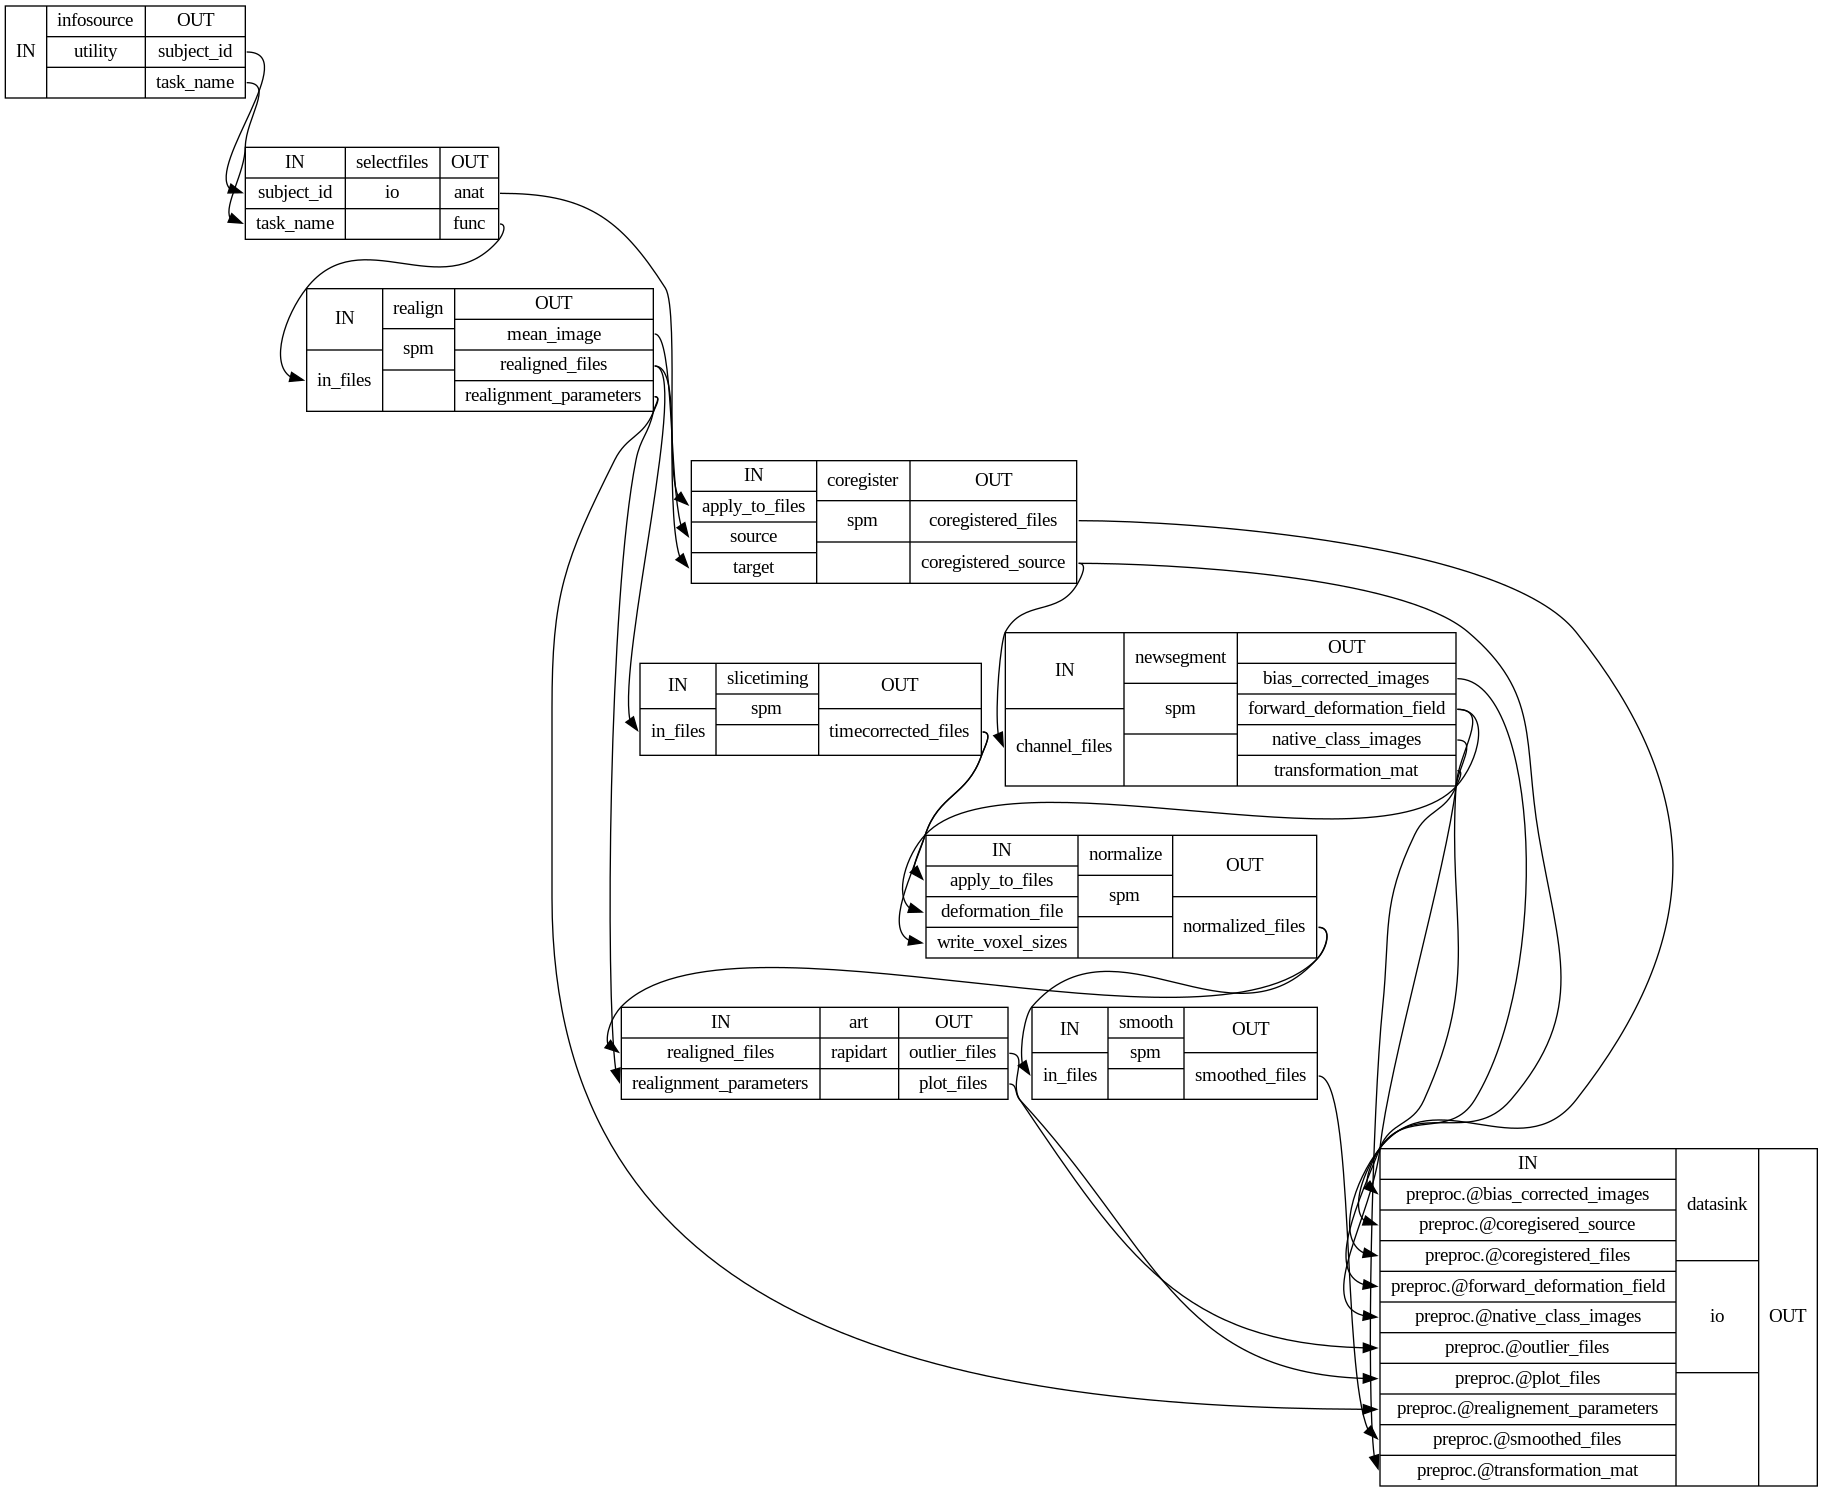

In [25]:
from IPython.display import Image
Image(filename='/home/matay/spmbasics/data/output/workingdir/block_preproc_art/flat_graph_detailed.png' )

In [26]:
preproc.run()

240517-16:47:04,572 nipype.workflow INFO:
	 Workflow block_preproc_art settings: ['check', 'execution', 'logging', 'monitoring']
240517-16:47:04,578 nipype.workflow INFO:
	 Running serially.
240517-16:47:04,579 nipype.workflow INFO:
	 [Node] Setting-up "block_preproc_art.selectfiles" in "/home/matay/spmbasics/data/output/workingdir/block_preproc_art/_subject_id_01_task_name_auditory/selectfiles".
240517-16:47:04,580 nipype.workflow INFO:
	 [Node] Executing "selectfiles" <nipype.interfaces.io.SelectFiles>
240517-16:47:04,581 nipype.workflow INFO:
	 [Node] Finished "selectfiles", elapsed time 0.000254s.
240517-16:47:04,582 nipype.workflow INFO:
	 [Node] Setting-up "block_preproc_art.realign" in "/home/matay/spmbasics/data/output/workingdir/block_preproc_art/_subject_id_01_task_name_auditory/realign".
240517-16:47:04,608 nipype.workflow INFO:
	 [Node] Executing "realign" <nipype.interfaces.spm.preprocess.Realign>


stty: 'standard input': Inappropriate ioctl for device


240517-16:47:36,291 nipype.workflow INFO:
	 [Node] Finished "realign", elapsed time 24.263663s.
240517-16:47:36,297 nipype.workflow INFO:
	 [Node] Setting-up "block_preproc_art.slicetiming" in "/home/matay/spmbasics/data/output/workingdir/block_preproc_art/_subject_id_01_task_name_auditory/slicetiming".
240517-16:47:36,299 nipype.workflow INFO:
	 [Node] Executing "slicetiming" <nipype.interfaces.spm.preprocess.SliceTiming>


stty: 'standard input': Inappropriate ioctl for device


240517-16:47:48,616 nipype.workflow INFO:
	 [Node] Finished "slicetiming", elapsed time 12.316054s.
240517-16:47:48,618 nipype.workflow INFO:
	 [Node] Setting-up "block_preproc_art.coregister" in "/home/matay/spmbasics/data/output/workingdir/block_preproc_art/_subject_id_01_task_name_auditory/coregister".
240517-16:47:48,633 nipype.workflow INFO:
	 [Node] Executing "coregister" <nipype.interfaces.spm.preprocess.Coregister>


stty: 'standard input': Inappropriate ioctl for device


240517-16:48:06,485 nipype.workflow INFO:
	 [Node] Finished "coregister", elapsed time 17.85063s.
240517-16:48:06,487 nipype.workflow INFO:
	 [Node] Setting-up "block_preproc_art.newsegment" in "/home/matay/spmbasics/data/output/workingdir/block_preproc_art/_subject_id_01_task_name_auditory/newsegment".
240517-16:48:06,491 nipype.workflow INFO:
	 [Node] Executing "newsegment" <nipype.interfaces.spm.preprocess.NewSegment>


stty: 'standard input': Inappropriate ioctl for device


240517-16:48:44,685 nipype.workflow INFO:
	 [Node] Finished "newsegment", elapsed time 38.193782s.
240517-16:48:44,688 nipype.workflow INFO:
	 [Node] Setting-up "block_preproc_art.normalize" in "/home/matay/spmbasics/data/output/workingdir/block_preproc_art/_subject_id_01_task_name_auditory/normalize".
240517-16:48:44,705 nipype.workflow INFO:
	 [Node] Executing "normalize" <nipype.interfaces.spm.preprocess.Normalize12>


stty: 'standard input': Inappropriate ioctl for device


240517-16:49:00,92 nipype.workflow INFO:
	 [Node] Finished "normalize", elapsed time 15.38626s.
240517-16:49:00,101 nipype.workflow INFO:
	 [Node] Setting-up "block_preproc_art.smooth" in "/home/matay/spmbasics/data/output/workingdir/block_preproc_art/_subject_id_01_task_name_auditory/smooth".
240517-16:49:00,106 nipype.workflow INFO:
	 [Node] Executing "smooth" <nipype.interfaces.spm.preprocess.Smooth>


stty: 'standard input': Inappropriate ioctl for device


240517-16:49:12,817 nipype.workflow INFO:
	 [Node] Finished "smooth", elapsed time 12.709783999999999s.
240517-16:49:12,819 nipype.workflow INFO:
	 [Node] Setting-up "block_preproc_art.art" in "/home/matay/spmbasics/data/output/workingdir/block_preproc_art/_subject_id_01_task_name_auditory/art".
240517-16:49:12,822 nipype.workflow INFO:
	 [Node] Executing "art" <nipype.algorithms.rapidart.ArtifactDetect>


stty: 'standard input': Inappropriate ioctl for device


240517-16:49:13,45 nipype.workflow INFO:
	 [Node] Finished "art", elapsed time 0.222566s.
240517-16:49:13,46 nipype.workflow INFO:
	 [Node] Setting-up "block_preproc_art.datasink" in "/home/matay/spmbasics/data/output/workingdir/block_preproc_art/_subject_id_01_task_name_auditory/datasink".
240517-16:49:13,50 nipype.workflow INFO:
	 [Node] Executing "datasink" <nipype.interfaces.io.DataSink>
240517-16:49:13,51 nipype.workflow INFO:
	 [Node] Finished "datasink", elapsed time 0.000974s.
